In [47]:
import math
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import itertools
import einops
from collections import defaultdict
import copy
from einops import einsum
from kornia.augmentation import RandomGaussianNoise

from decomp.model import Model, FFNModel, _Config
from decomp.datasets import MNIST, FMNIST, _CIFAR10
from decomp.plotting import plot_explanation, plot_eigenspectrum

from torch_polyapprox.ols import ols

# init configs
device = 'cuda:3'
dataset = 'cifar' # or cifar
plotting = False
train_bilinear = False
train_unreg = True
noise_std = 1.0

#checkpoint_epochs = []
checkpoint_epochs = [1, 2, 4, 8, 16, 32, 64, 128]

if dataset == 'mnist':
    d_input = 784
    train, test = MNIST(train=True, device=device), MNIST(train=False, device=device)
    ut = None
    t = RandomGaussianNoise(std=noise_std)
elif dataset == 'fmnist':
    d_input = 784
    train, test = FMNIST(train=True, device=device), FMNIST(train=False, device=device)
    ut = None
    t = RandomGaussianNoise(std=noise_std)
else: # 'cifar'
    d_input = 3072
    train, test = _CIFAR10(train=True, device=device), _CIFAR10(train=False, device=device)
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std = (0.2023, 0.1994, 0.2010)
    ut = transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    # Normalization transform
    t = transforms.Compose([RandomGaussianNoise(std=noise_std), ut])

if train_unreg:
    t = ut
configs = {
    'wd': 0.2,
    'epochs': 128,
    'd_input': d_input,
    'bias': True,
}

Files already downloaded and verified
Files already downloaded and verified


### CIFAR adjusted training

In [48]:
relu_model = FFNModel.from_config(
            #lr=1e-3,
            wd=configs['wd'],
            epochs=configs['epochs'],
            batch_size=2048,
            #d_hidden=256, # for cifar
            d_input=configs['d_input'], # for cifar
            #d_output=10,
            bias=configs['bias']
).to(device)
#relu_metrics_reg_cifar = relu_model_reg_cifar.fit(train, test)
relu_metrics = relu_model.fit(train, test, transform=t, test_transform=True, 
                              checkpoint_epochs=checkpoint_epochs)

  0%|          | 0/128 [00:00<?, ?it/s]

train/loss: 0.171, train/acc: 0.981, val/loss: 1.917, val/acc: 0.521: 100%|██████████| 128/128 [00:52<00:00,  2.42it/s]


In [49]:
# Assuming checkpoints is the list containing tuple of (epoch, state_dict)
# For example: [(0, state_dict0), (1, state_dict1), ...]

def load_checkpoint(epoch, model_label='1l_cifar', mode='with_noise', config=configs):
    # Find the checkpoint for the desired epoch
    path = f'/mnt/ssd-1/mechinterp/alice/polyapprox/polyapprox/experiments/ckpts/{mode}/{model_label}/'
    model_name = f'relu_model_epoch{str(epoch).zfill(4)}.pth'
    model = FFNModel.from_config(
            wd=config['wd'],
            epochs=config['epochs'],
            d_input=config['d_input'],
            bias=config['bias'])
    checkpoint = torch.load(path + model_name)#if epoch not in checkpoints:
    #    raise ValueError(f"No checkpoint found for epoch {epoch}")

    # Load the state_dict into the model
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

checkpoints = [load_checkpoint(epoch, '1l_cifar', 'without_noise') for epoch in checkpoint_epochs]

/tmp/ipykernel_221924/957714051.py:13: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [50]:
# visualize sample image.
sample_img = test.x[1].squeeze().cpu()
print(sample_img.shape)
#px.imshow(sample_img)
px.imshow(sample_img.permute(1,2,0))

torch.Size([3, 32, 32])


### Normal training, ignore CIFAR for now

In [ ]:
relu_model_u = FFNModel.from_config(
            wd=wd,
            epochs=epochs,
            d_input=d_input, # for cifar
            bias=True
).to(device)

relu_metrics_u = relu_model_u.fit(train, test, transform=ut, test_transform=True)

train/loss: 0.971, train/acc: 0.687, val/loss: 1.334, val/acc: 0.533: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


In [32]:

# bilinear baseline model. Decompose using tdooms/michael methods
if train_bilinear:
    bilinear_model = Model.from_config(epochs=epochs, wd=wd, d_input=d_input, bias=True).to(device)
    bilinear_metrics = bilinear_model.fit(train, test, RandomGaussianNoise(std=noise_std))

# relu mnist model to approximate and decompose
relu_model = FFNModel.from_config(
            lr=1e-3,
            wd=0.5,
            epochs=epochs,
            batch_size=2048,
            d_hidden=256, # for cifar
            d_input=d_input, # for cifar
            d_output=10,
            bias=True
).to(device)

relu_metrics = relu_model.fit(train, test, RandomGaussianNoise(std=noise_std))
# unregularized
if train_unreg:
    relu_model_unreg = FFNModel.from_config(
                lr=1e-3,
                wd=0.5,
                epochs=epochs,
                batch_size=2048,
                d_hidden=256, # for cifar
                d_input=d_input, # for cifar
                d_output=10,
                bias=True
    ).to(device)

    relu_metrics_unreg = relu_model_unreg.fit(train, test)

train/loss: 0.076, train/acc: 0.979, val/loss: 0.066, val/acc: 0.980: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]
train/loss: 0.029, train/acc: 0.995, val/loss: 0.068, val/acc: 0.979: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [8]:
for i in ckpts:
    print(i['epoch'])

1
2
4
8
16
32
64
128


In [51]:
# analytic fit approximations ~ 2s for mnist
from extra.ipynb_utils import fit_approxs, gamma_to_B, test_inner, test_outer, \
    adv_svd, test_svd_perf, show_results, plot_svd_results, test_model_acc
from tqdm import tqdm

def approx_fit(model, order='linear'):
    W1 = model.w_e.detach()
    W2 = model.w_u.detach()
    b1 = model.embed.bias.detach()#.cpu().data.numpy()
    b2 = model.head.bias.detach()
    return ols(W1, b1, W2, b2, act='relu', order=order)

def lin_fit_checkpoints(checkpoints=checkpoints):
    lin_fits = []
    for idx in tqdm(range(len(checkpoints))):
        ckpt_model=checkpoints[idx]
        lin_fits.append(approx_fit(ckpt_model))
    return lin_fits

def quad_fit_checkpoints(checkpoints=checkpoints):
    quad_fits = []
    for idx in tqdm(range(len(checkpoints))):
        ckpt_model = checkpoints[idx]
        quad_fits.append(approx_fit(ckpt_model, order='quadratic'))
    return quad_fits


ckpt_lin_fits = lin_fit_checkpoints()
ckpt_quad_fits = quad_fit_checkpoints()

 25%|██▌       | 2/8 [00:00<00:00, 12.93it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 50%|█████     | 4/8 [00:00<00:00, 11.96it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


  0%|          | 0/8 [00:00<?, ?it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 12%|█▎        | 1/8 [00:31<03:41, 31.58s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 25%|██▌       | 2/8 [01:07<03:26, 34.34s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 38%|███▊      | 3/8 [01:43<02:53, 34.74s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 50%|█████     | 4/8 [02:17<02:19, 34.81s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 62%|██████▎   | 5/8 [02:49<01:40, 33.44s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 75%|███████▌  | 6/8 [03:21<01:05, 32.97s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


 88%|████████▊ | 7/8 [03:56<00:33, 33.62s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


100%|██████████| 8/8 [04:30<00:00, 33.84s/it]


In [58]:
#for idx in tqdm(checkpoint_epochs):
#    ckpt_model = load_checkpoint(ckpts, idx, config=configs)
test=_CIFAR10(train=True, device='cpu')
#ut = None # use if f/mnist; comment if cifar
ut = transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
relu_accs = [test_model_acc(mod, test_set=test, transform=ut) for mod in tqdm(checkpoints)]
linr_accs = [test_model_acc(fit, test_set=test, transform=ut) for fit in tqdm(ckpt_lin_fits)]
quadr_accs = [test_model_acc(fit, test_set=test, transform=ut) for fit in tqdm(ckpt_quad_fits)]

Files already downloaded and verified


100%|██████████| 8/8 [00:25<00:00,  3.18s/it]


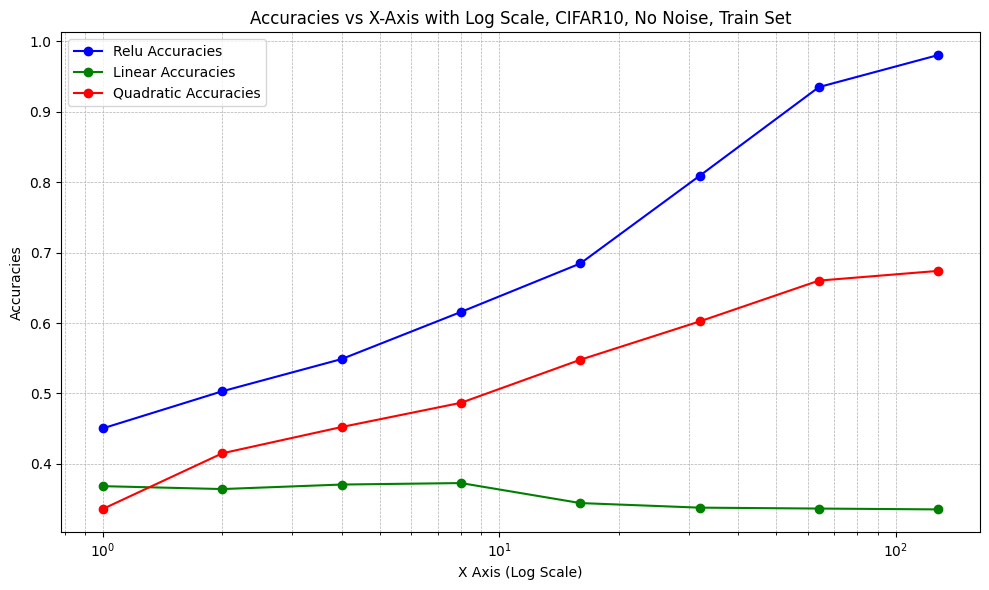

In [59]:
data = {'x': checkpoint_epochs, 'Relu': relu_accs,
        'Linear': linr_accs, 'Quadratic': quadr_accs}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
plt.plot(df['x'], df['Relu'], marker='o', color='blue', label='Relu Accuracies')
plt.plot(df['x'], df['Linear'], marker='o', color='green', label='Linear Accuracies')
plt.plot(df['x'], df['Quadratic'], marker='o', color='red', label='Quadratic Accuracies')

# Set x-axis to log scale
plt.xscale('log')

# Add labels and title
plt.xlabel('X Axis (Log Scale)')
plt.ylabel('Accuracies')
plt.title('Accuracies vs X-Axis with Log Scale, CIFAR10, No Noise, Train Set')
plt.legend()

# Show the plot
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [16]:
all_relu_models = [load_checkpoint(ckpts, idx) for idx in checkpoint_epochs]
#relu_accs = [test_model_acc(load_checkpoint(ckpts, idx), test_set=test, transform=t)
#             for idx in tqdm(checkpoint_epochs)]
all_relu_models

[FFNModel(
   (embed): Linear(
     in_features=3072, out_features=256, bias=True
     (gate): Identity()
   )
   (activation): ReLU()
   (head): Linear(
     in_features=256, out_features=10, bias=True
     (gate): Identity()
   )
   (criterion): CrossEntropyLoss()
 ),
 FFNModel(
   (embed): Linear(
     in_features=3072, out_features=256, bias=True
     (gate): Identity()
   )
   (activation): ReLU()
   (head): Linear(
     in_features=256, out_features=10, bias=True
     (gate): Identity()
   )
   (criterion): CrossEntropyLoss()
 ),
 FFNModel(
   (embed): Linear(
     in_features=3072, out_features=256, bias=True
     (gate): Identity()
   )
   (activation): ReLU()
   (head): Linear(
     in_features=256, out_features=10, bias=True
     (gate): Identity()
   )
   (criterion): CrossEntropyLoss()
 ),
 FFNModel(
   (embed): Linear(
     in_features=3072, out_features=256, bias=True
     (gate): Identity()
   )
   (activation): ReLU()
   (head): Linear(
     in_features=256, out_feature

In [17]:
if train_bilinear:
    bvals, bvecs = bilinear_model.decompose()
    if plotting:
        px.imshow(bvecs[0, -1].view(-1, 28).cpu(), color_continuous_midpoint=0, color_continuous_scale="RdBu")

x = test.x.flatten(start_dim=1)[:100,:]
torch.allclose(test_inner(x), test_outer(x), atol=1e-5)

4720128
torch.Size([10, 3072, 3072]) torch.Size([100, 3072])
torch.Size([100, 4720128]) torch.Size([10, 4720128])


False

~~Up to 460G ram used lol, VIRT 576~~ Fixed, uses low ram.

In [8]:
# error uh oh: testing on unmodified input dataset.

linr_acc = test_model_acc(lin_01r, test_set=test, transform=t)
relur_acc = test_model_acc(relu_model, test_set=test, transform=t)
quadr_acc = test_model_acc(quad01r, test_set=test, transform=t)
linu_acc = test_model_acc(lin_01u, test_set=test, transform=ut)
reluu_acc = test_model_acc(relu_model_u, test_set=test, transform=ut)
quadu_acc = test_model_acc(quad01u, test_set=test, transform=ut)
print(f'regularized 0.4: {relur_acc:.4f}, {linr_acc:.4f}, {quadr_acc:.4f}')
print(f'unregularized  : {reluu_acc:.4f}, {linu_acc:.4f}, {quadu_acc:.4f}')
if train_bilinear:
    bili_acc = test_model_acc(bilinear_model)
    print(f'{bili_acc:.4f}')

regularized 0.4: 0.4347, 0.2988, 0.3504
unregularized  : 0.5333, 0.3415, 0.4478


In [37]:
# SVD section
import plotly.express as px

ur, sr, vr = torch.svd(quad01r.beta)
assert torch.allclose(quad01r.beta, ur @ (torch.diag(sr) @ vr.T), atol=1e-6)

#px.imshow(u[:10].reshape((-1,28)).T, color_continuous_midpoint=0, color_continuous_scale="RdBu")
#px.imshow(u.T.reshape((280,28)).T, color_continuous_midpoint=0, color_continuous_scale="RdBu")

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torc

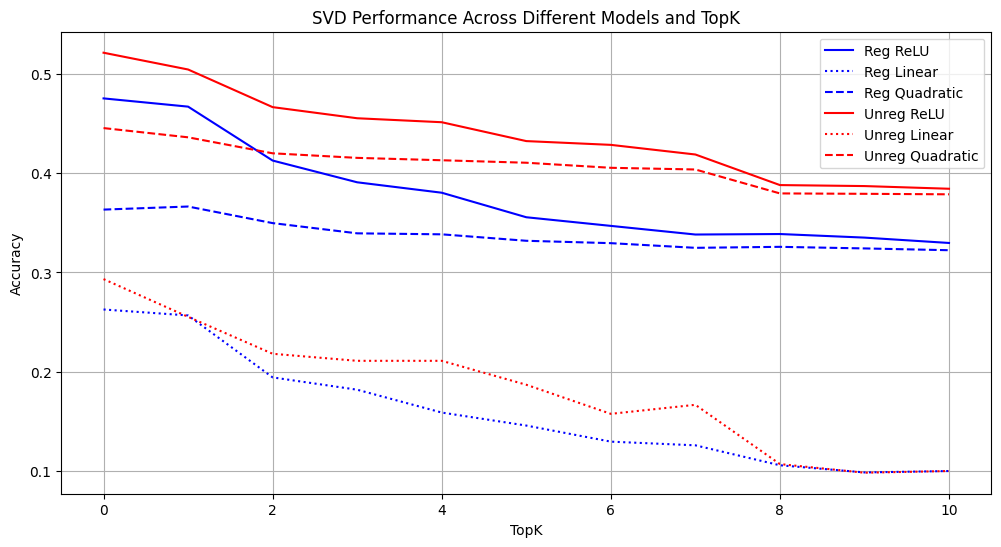

In [ ]:
acc_loss = lambda y_hat, y: (y_hat.argmax(dim=-1) == y).float().mean()
model_pair = (relu_model, relu_model_u)
transform_pair = (t,ut)

df4 = show_results(model_pair, transform_pair=transform_pair, loss=acc_loss)
plot_svd_results(df4)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torc

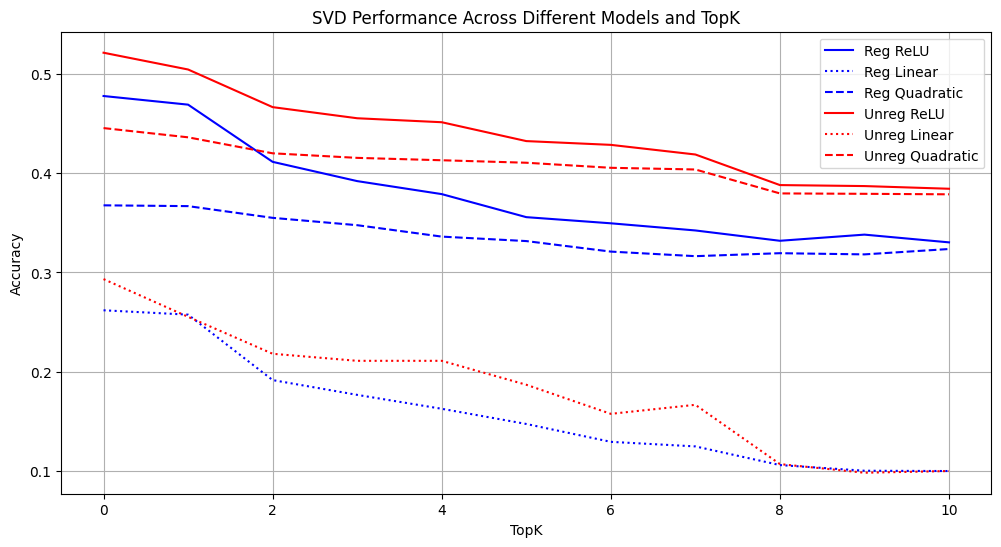

In [63]:
model_pair = (relu_model_reg_cifar, relu_model_unreg_cifar)
transform_pair = (t,ut)

df3 = show_results(model_pair, transform_pair=transform_pair)
plot_svd_results(df3)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torc

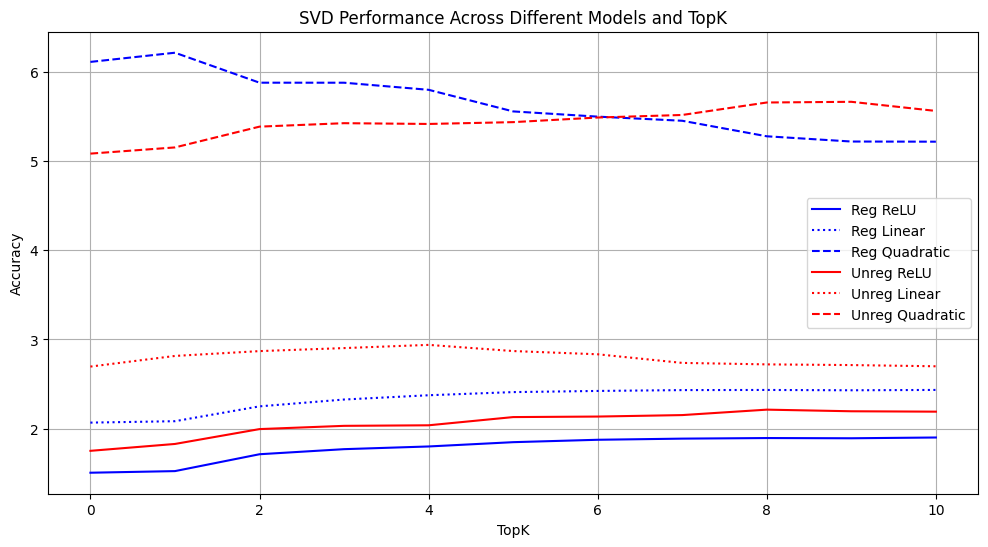

In [ ]:
model_pair = (relu_model, relu_model_u)
transform_pair = (t,ut)

# default: transformer_pair(None,None)
#df = show_results(model_pair, transform_pair=transform_pair)
df2 = show_results(model_pair, transform_pair=transform_pair, loss=nn.CrossEntropyLoss())
plot_svd_results(df2)

In [ ]:
reg_base_accs, reg_line_accs, reg_quad_accs = test_svd_perf(model_pair[0], transform=transform_pair[0], loss=None)
unr_base_accs, unr_line_accs, unr_quad_accs = test_svd_perf(model_pair[1], transform=transform_pair[1], loss=None)
rows = []
#reg_base_accs, reg_line_accs, reg_quad_accs = test_svd_perf(model_pair[0], transform=transform_pair[0], loss=loss)
#print(reg_base_accs)
#unr_base_accs, unr_line_accs, unr_quad_accs = test_svd_perf(model_pair[1], transform=transform_pair[1], loss=loss)
#print(unr_base_accs)
for i in range(11):
    rows.append((i, reg_base_accs[i], reg_line_accs[i], reg_quad_accs[i],
                    unr_base_accs[i], unr_line_accs[i], unr_quad_accs[i]))

df = pd.DataFrame(rows, columns=['TopK', 'regRelu', 'regLinear', 'regQuadratic',
                                    'unregRelu', 'unregLinear', 'unregQuadratic'])

plot_svd_results(df)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torch.Size([10000, 3072])
torc

[0.4675999879837036,
 0.47099998593330383,
 0.40720000863075256,
 0.3921000063419342,
 0.3806000053882599,
 0.3571000099182129,
 0.3547999858856201,
 0.34040001034736633,
 0.3377000093460083,
 0.334199994802475,
 0.3319000005722046]

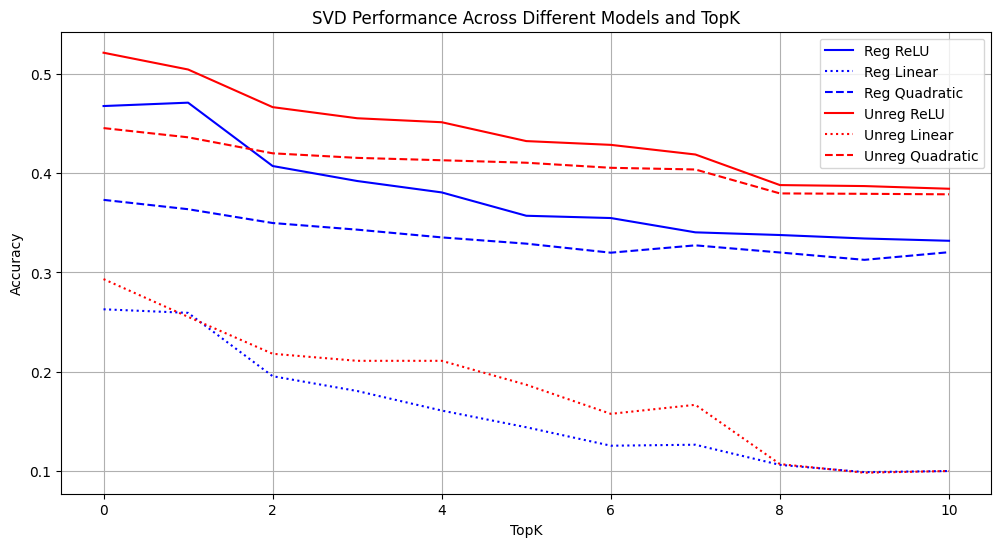

In [57]:
rows = []
#reg_base_accs, reg_line_accs, reg_quad_accs = test_svd_perf(model_pair[0], transform=transform_pair[0], loss=loss)
#print(reg_base_accs)
#unr_base_accs, unr_line_accs, unr_quad_accs = test_svd_perf(model_pair[1], transform=transform_pair[1], loss=loss)
#print(unr_base_accs)
for i in range(11):
    rows.append((i, reg_base_accs[i], reg_line_accs[i], reg_quad_accs[i],
                    unr_base_accs[i], unr_line_accs[i], unr_quad_accs[i]))

df = pd.DataFrame(rows, columns=['TopK', 'regRelu', 'regLinear', 'regQuadratic',
                                    'unregRelu', 'unregLinear', 'unregQuadratic'])

plot_svd_results(df)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([256])
torch.Size([256])


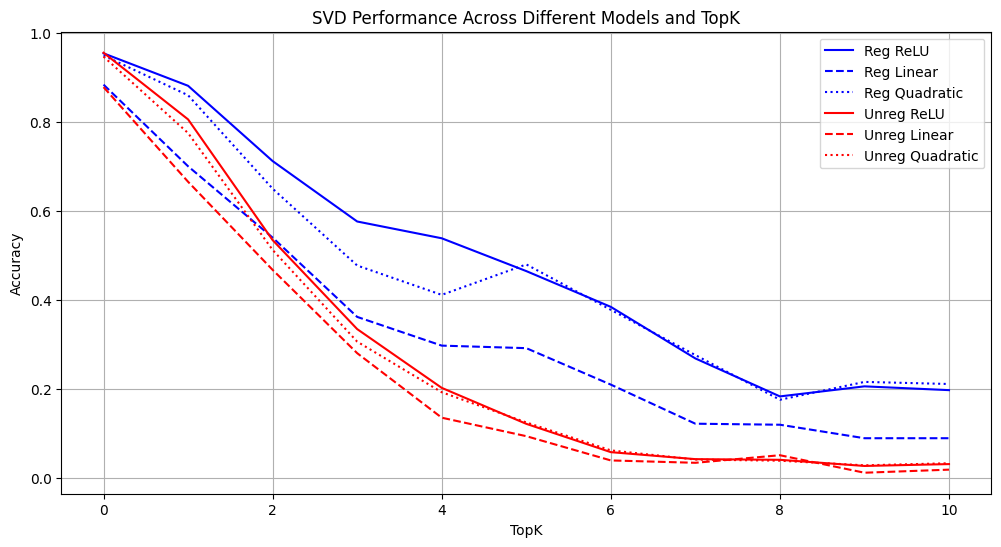

In [ ]:
def plot_svd_results(df):
    plt.figure(figsize=(12, 6))

    # Plot for regulated models
    plt.plot(df['TopK'], df['regRelu'], color='b', label='Reg ReLU', linestyle='-')
    plt.plot(df['TopK'], df['regLinear'], color='b', label='Reg Linear', linestyle='--')
    plt.plot(df['TopK'], df['regQuadratic'], color='b', label='Reg Quadratic', linestyle=':')

    # Plot for unregulated models
    plt.plot(df['TopK'], df['unregRelu'], color='r', label='Unreg ReLU', linestyle='-')
    plt.plot(df['TopK'], df['unregLinear'], color='r', label='Unreg Linear', linestyle='--')
    plt.plot(df['TopK'], df['unregQuadratic'], color='r', label='Unreg Quadratic', linestyle=':')

    # Adding a title and labels
    plt.title('SVD Performance Across Different Models and TopK')
    plt.xlabel('TopK')
    plt.ylabel('Accuracy')
    
    # Add grid
    plt.grid()

    # Show the legend
    plt.legend()
    
    # Show the plot
    plt.show()

# Call the plotting function
plot_svd_results(df)

In [20]:
import pandas as pd

def show_results(topk=1):
    # Define models and transformations to test, paired with descriptor strings
    models_transforms = []
    for i in range(1, topk + 1):
        models_transforms.append(('relu', 'regularized', relu_model, i, adv_svd(ur, topk=i)))
        models_transforms.append(('lin', 'regularized', lin_01r, i, adv_svd(ur, topk=i)))
        models_transforms.append(('quad', 'regularized', quad01r, i, adv_svd(ur, topk=i)))
        models_transforms.append(('relu', 'unregularized', relu_model_unreg, i, adv_svd(uu, topk=i)))
        models_transforms.append(('lin', 'unregularized', lin_01u, i, adv_svd(uu, topk=i)))
        models_transforms.append(('quad', 'unregularized', quad01u, i, adv_svd(uu, topk=i)))

    # Collect results
    results = []
    for name, mode, model, i, transform in models_transforms:
        svd_acc = test_model_acc(model, transform=transform)
        results.append((i, name, mode, svd_acc))

    # Create a DataFrame with separate columns for model types
    df = pd.DataFrame(results, columns=['TopK', 'Model', 'Regularization', 'SVD Atk'])

    # Pivot the DataFrame to have separate columns for each model type
    pivot_table = df.pivot_table(index=['TopK', 'Regularization'], 
                                  columns='Model', 
                                  values='SVD Atk', 
                                  aggfunc='first')

    # Flatten the multi-index columns
    pivot_table.columns.name = None  # remove the categories name
    pivot_table.reset_index(inplace=True)

    # Print the dataframe
    return pivot_table

show_results(topk=10)

,TopK,Regularization,lin,quad,relu
0,1,regularized,0.7000,0.8595,0.8808
1,1,unregularized,0.6978,0.8226,0.8645
2,2,regularized,0.5398,0.6497,0.7117
3,2,unregularized,0.4957,0.6630,0.7268
4,3,regularized,0.3617,0.4771,0.5760
5,3,unregularized,0.4222,0.5606,0.6575
6,4,regularized,0.2972,0.4112,0.5383
7,4,unregularized,0.3940,0.4963,0.5778
8,5,regularized,0.2915,0.4796,0.4646
9,5,unregularized,0.4097,0.5364,0.5358


### Viz images

In [17]:
def test_model_acc(model, test_set=test, num_samples=10000, transform = None):
    assert 0 <= num_samples <= test_set.y.size(0), 'num_samples too large!!'
    accuracy = lambda y_hat, y: (y_hat.argmax(dim=-1) == y).float().mean()
    if transform is not None:
        inp = torch.einsum('ij,bj->bi', transform, test.x.flatten(start_dim=1))
    else:
        inp = test.x.flatten(start_dim=1)
    fwd = model(inp[:num_samples])
    return accuracy(fwd, test_set.y[:num_samples]).item()

transform = adv_svd(uu)
images = test.x.flatten(start_dim=1)
images_u = torch.einsum('ij,bj->bi', adv_svd(uu, topk=1), images)
images_r = torch.einsum('ij,bj->bi', adv_svd(ur, topk=1), images)

In [71]:
#data = test.x.flatten(start_dim=1)
px.imshow(images[0].numpy().reshape(28,28))

In [18]:
px.imshow(images_u[0].numpy().reshape(28,28))

In [19]:
px.imshow(images_r[0].numpy().reshape(28,28))

### Unnecessary code for now

In [ ]:
def decompose(self):
    """tdoom reference code on Model object."""
    # Split the bilinear layer into the left and right components
    l, r = self.w_lr[0].unbind()
    b = einsum(self.w_u, l, r, "cls out, out in1, out in2 -> cls in1 in2")
    b = 0.5 * (b + b.mT)
    vals, vecs = torch.linalg.eigh(b)
    vecs = einsum(vecs, self.w_e, "cls emb comp, emb inp -> cls comp inp")
    return vals, vecs

In [113]:
px.imshow(b[:, 0].view(-1, 28).cpu(), color_continuous_midpoint=0, color_continuous_scale="RdBu")

In [ ]:
# recentered quadratic approximation using 2Ax+b=0. Done enough
import torch

# Define dimensions
n = 784

# Create a random symmetric matrix A
A = torch.randn(n, n)
A = (A + A.T) / 2  # Make it symmetric

# Create random vector b and scalar c
b = torch.randn(n, 2)
c = torch.rand(2)

# Define input vector x
x = torch.randn(n, 2)

# Original quadratic expression: x^T A x + b^T x + c
def original_quadratic(x):
    return (x.T @ A @ x) + (b.T @ x) + c

# Complete the square by finding x_0
A_inv = torch.inverse(A)
x_0 = -0.5 * A_inv @ b
x0 = -0.5 * torch.linalg.solve(A,b)
# Substitute x = x_0 + z
y = x - x_0
yy = x - x0
# Rewritten quadratic expression: z^T A z + other constant terms
def rewritten_quadratic(y):
    constant_term = 0.25 * (b.T @ A_inv @ b) - 0.5 * (b.T @ A_inv @ b) + c  # Correct constant offset
    return (y.T @ A @ y) + constant_term

# Evaluate both the original and rewritten forms
original_value = original_quadratic(x)
rewritten_value = rewritten_quadratic(y)
z = rewritten_quadratic(yy)
print(original_value, rewritten_value, z)
# Check if the original and transformed expressions are equal
print(torch.allclose(original_value, rewritten_value, rtol=1e-1))#, "The expressions are not equal."
print(torch.allclose(original_value, z, rtol=1.0))
print(torch.allclose(rewritten_value, z, atol=2e-1))
print("The original and final quadratic expressions are equal!")

tensor([[1342.6851,  371.1395],
        [ 356.6680, -618.2236]]) tensor([[1330.5361,  370.9978],
        [ 369.6768, -621.0649]]) tensor([[1329.3665,  371.3304],
        [ 369.0887, -621.0721]])
True
True
False
The original and final quadratic expressions are equal!


### Fitting third order tensor

In [10]:
quad01r.gamma.shape, quad01r.beta.shape, quad01r.alpha.shape

(torch.Size([10, 4720128]), torch.Size([3072, 10]), torch.Size([10]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from pandas import DataFrame

def _collator(transform=None):
    def inner(batch):
        x = torch.stack([item[0] for item in batch]).float()
        y = torch.stack([item[1] for item in batch])
        return (x, y) if transform is None else (transform(x), y)
    return inner
# Custom quadratic model
class QuadraticModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuadraticModel, self).__init__()
        # A will be a lower triangular matrix represented as a vector
        self.gamma = nn.Parameter(torch.randn(output_dim, (input_dim * (input_dim + 1)) // 2))
        self.beta = nn.Parameter(torch.randn(input_dim, output_dim))
        self.alpha = nn.Parameter(torch.randn(1, output_dim))
        self.input_dim = input_dim
        self.lr = 1e-3
        self.wd = 0.5
        self.batch_size = 10000
        self.seed = 42
        self.criterion = nn.MSELoss()
        self.accuracy = lambda y_hat, y: (y_hat.argmax(dim=-1) == y).float().mean()
        self.epochs = 10

    def get_gamma_tensor(self):
        nrows = self.input_dim
        gamma_tensor = torch.zeros((self.gamma.shape[0], nrows, nrows))
        rows, cols = torch.tril_indices(nrows, nrows)
        gamma_tensor[:, rows, cols] = self.gamma
        return 0.5 * (gamma_tensor + gamma_tensor.mT)

    def forward(self, x):
        y = x @ self.beta + self.alpha
        y += torch.einsum('hij,bi,bj->bh', self.get_gamma_tensor(), x, x)
        return y
    
    def step(self, x, y, eval_mode=False):
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        #acc = self.accuracy(y_hat, y)
        acc = 0.0
        if eval_mode:
            acc = self.accuracy(y_hat, y)
        return loss, acc
    def fit(self, train, test, test_transf=None):
        torch.manual_seed(self.seed)
        torch.set_grad_enabled(True)

        optimizer = AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.epochs)
        test_loader = DataLoader(test, batch_size=test.y.size(0), shuffle=False,
                                 drop_last=True, collate_fn=_collator(test_transf))

        pbar = tqdm(range(self.epochs), disable=False)
        history = []
        
        train_loader = DataLoader(train, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test, batch_size=self.batch_size, shuffle=False,
                                 drop_last=True, collate_fn=_collator(test_transf))
        for _ in pbar:
            epoch_list = []
            for x, y in train_loader:
                optimizer.zero_grad()
                mse_loss, _ = self.train().step(x, y)
                mse_loss.backward()
                optimizer.step()
                
                epoch_list += [mse_loss.item()]
            scheduler.step()
            test_x, test_y = next(iter(test_loader))
            #self.eval()
            #with torch.no_grad():
            val_mse_loss, acc = self.eval().step(test_x, test_y, eval_mode=True)

            metrics = {
                "train/mseloss": sum(loss for loss in epoch_list) / len(epoch_list),
                "val/acc": acc.item(),
                "val/mse_loss": val_mse_loss.item()
            }

            history.append(metrics)
            pbar.set_description(', '.join(f"{k}: {v:.3f}" for k, v in metrics.items()))

        torch.set_grad_enabled(False)
        return DataFrame.from_records(history, columns=['train/loss', 'train/acc', 'val/loss', 'val/acc'])
    
# Define your parameters
input_dim = 3072  # Input feature dimension
output_dim = 10  # Number of output neurons
num_samples = 100_000
model = QuadraticModel(input_dim, output_dim)

train_x = torch.randn(num_samples, input_dim)
train_y = relu_model(train_x)
train_dataset = TensorDataset(train_x, train_y)
test_dataset = _CIFAR10(device='cpu')

model.fit(train_dataset, test_dataset, test_transf=t)

In [33]:
# Define your parameters
input_dim = 3072  # Input feature dimension
output_dim = 10  # Number of output neurons
num_samples = 100_000
model = QuadraticModel(input_dim, output_dim)

train_x = torch.randn(num_samples, input_dim)
train_y = relu_model(train_x)
train_dataset = TensorDataset(train_x, train_y)
test_dataset = _CIFAR10(device='cpu')

model.fit(train_dataset, test_dataset, test_transf=t)

Files already downloaded and verified


  0%|          | 0/10 [00:10<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
        #batch_size = x.size(0)
        
        # Reshape A_params to a lower triangular matrix per output dimension
        A_matrix = torch.zeros((self.input_dim, self.input_dim, self.A.size(1)), device=x.device)
        tril_indices = torch.tril_indices(row=self.input_dim, col=self.input_dim, offset=0)
        
        # Build symmetric matrices for each output dimension
        #for i in range(self.A_params.size(1)):
        A_matrix[tril_indices[0], tril_indices[1], :] = self.A[:, :]
        A_matrix[tril_indices[1], tril_indices[0], :] = self.A[:, :]
        
        # Calculate x^T A x for batch of inputs 
        quad_term = torch.bmm(x.unsqueeze(1), torch.bmm(A_matrix.permute(2, 0, 1), x.unsqueeze(2))).squeeze()
        
        # Calculate quadratic + linear + bias term for each output dimension
        linear_term = x.matmul(self.B)
        return quad_term + linear_term + self.c